<a href="https://colab.research.google.com/github/Sayed-Hossein-Hosseini/HydroWizard_Intelligent_Fuzzy_Logic_Irrigation/blob/master/HydroWizard_Intelligent_Fuzzy_Logic_Irrigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HydroWizard_Intelligent_Fuzzy_Logic_Irrigation**

## **Libraries**

In [1]:
!pip install scikit-fuzzy

import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from skfuzzy.defuzzify import defuzz
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 9.7 MB/s eta 0:00:00


## **Membership Functions**

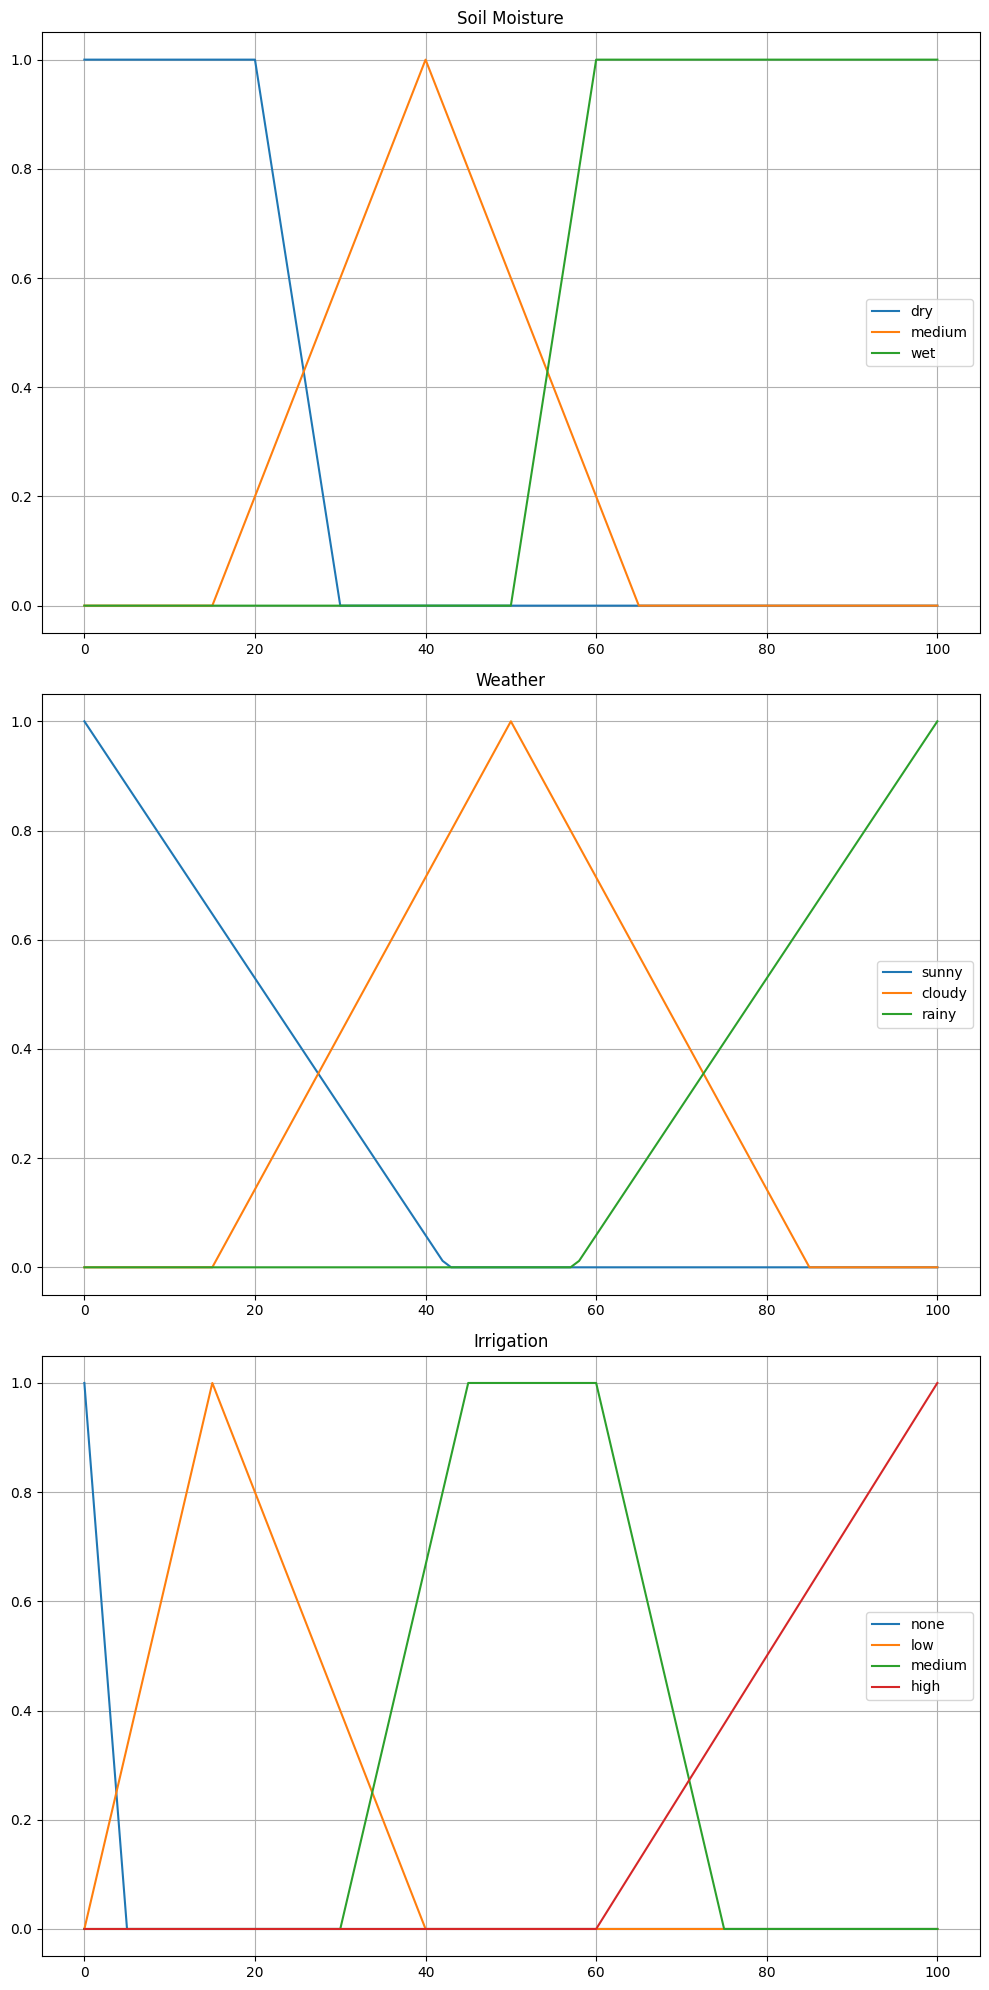

In [13]:
# Define the range of each variable (from 0 to 100)
soil_moisture = np.arange(0, 101, 1)
weather_range = np.arange(0, 101, 1)
irrigation_range = np.arange(0, 101, 1)

# Define fuzzy variables
soil = ctrl.Antecedent(soil_moisture, 'soil')
weather = ctrl.Antecedent(weather_range, 'weather')
irrigation = ctrl.Consequent(irrigation_range, 'irrigation')

# Membership functions for soil
soil['dry'] = fuzz.trapmf(soil.universe, [-1, 0, 20, 30])
soil['medium'] = fuzz.trimf(soil.universe, [15, 40, 65])
soil['wet'] = fuzz.trapmf(soil.universe, [50, 60, 100, 101])

# Membership functions for weather
weather['sunny'] = fuzz.trimf(weather.universe, [0, 0, 42.5])
weather['cloudy'] = fuzz.trimf(weather.universe, [15, 50, 85])
weather['rainy'] = fuzz.trimf(weather.universe, [57.5, 100, 100])

# Membership functions for irrigation
irrigation['none'] = fuzz.trimf(irrigation.universe, [-1, 0, 5])
irrigation['low'] = fuzz.trimf(irrigation.universe, [0, 15, 40])
irrigation['medium'] = fuzz.trapmf(irrigation.universe, [30, 45, 60, 75])
irrigation['high'] = fuzz.trimf(irrigation.universe, [60, 100, 101])

def plot_mf(var, var_name, ax):
    for label in var.terms:
        mf = var.terms[label].mf
        ax.plot(var.universe, mf, label=label)
    ax.set_title(var_name)
    ax.legend()
    ax.grid(True)

# Plotting the fuzzy sets
fig, axs = plt.subplots(nrows=3, figsize=(10, 20))
# axs = axs.flatten()

plot_mf(soil, 'Soil Moisture', axs[0]) # Plot fuzzy sets for soil moisture
plot_mf(weather, 'Weather', axs[1]) # Plot fuzzy sets for weather
plot_mf(irrigation, 'Irrigation', axs[2]) # Plot fuzzy sets for irrigation

plt.tight_layout()
plt.show()

## **Control Rules and Defuzzification**

### **Fuzzy Logic Rules**

In [14]:
# Define fuzzy rules based on the given chart
rule1 = ctrl.Rule(soil['dry'] & weather['sunny'], irrigation['high'])
rule2 = ctrl.Rule(soil['dry'] & weather['cloudy'], irrigation['medium'])
rule3 = ctrl.Rule(soil['dry'] & weather['rainy'], irrigation['low'])

rule4 = ctrl.Rule(soil['medium'] & weather['sunny'], irrigation['medium'])
rule5 = ctrl.Rule(soil['medium'] & weather['cloudy'], irrigation['low'])
rule6 = ctrl.Rule(soil['medium'] & weather['rainy'], irrigation['none'])

rule7 = ctrl.Rule(soil['wet'] & weather['sunny'], irrigation['low'])
rule8 = ctrl.Rule(soil['wet'] & weather['cloudy'], irrigation['none'])
rule9 = ctrl.Rule(soil['wet'] & weather['rainy'], irrigation['none'])

### **Control Rules**

In [15]:
# Create the control system and simulation
irrigation_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
irrigation_sim = ctrl.ControlSystemSimulation(irrigation_ctrl)

### **Defuzzification**

#### **Membership Level Of Entries**

In [16]:
def input_value(soil_val=30, weather_val=20):
    return soil_val, weather_val

soil_val, weather_val = input_value()

μ_soil_dry = fuzz.interp_membership(soil.universe, soil['dry'].mf, soil_val)
μ_soil_medium = fuzz.interp_membership(soil.universe, soil['medium'].mf, soil_val)
μ_soil_wet = fuzz.interp_membership(soil.universe, soil['wet'].mf, soil_val)

μ_weather_sunny = fuzz.interp_membership(weather.universe, weather['sunny'].mf, weather_val)
μ_weather_cloudy = fuzz.interp_membership(weather.universe, weather['cloudy'].mf, weather_val)
μ_weather_rainy = fuzz.interp_membership(weather.universe, weather['rainy'].mf, weather_val)

print("Soil Membership Degrees:")
print(f"  Dry:    {μ_soil_dry:.2f}")
print(f"  Medium: {μ_soil_medium:.2f}")
print(f"  Wet:    {μ_soil_wet:.2f}")

print("Weather Membership Degrees:")
print(f"  Sunny:  {μ_weather_sunny:.2f}")
print(f"  Cloudy: {μ_weather_cloudy:.2f}")
print(f"  Rainy:  {μ_weather_rainy:.2f}")

Soil Membership Degrees:
  Dry:    0.00
  Medium: 0.60
  Wet:    0.00
Weather Membership Degrees:
  Sunny:  0.53
  Cloudy: 0.14
  Rainy:  0.00


#### **Activation Rules**

In [17]:
activation_rule1 = np.fmin(μ_soil_dry, μ_weather_sunny)     # → irrigation high
activation_rule2 = np.fmin(μ_soil_dry, μ_weather_cloudy)    # → irrigation medium
activation_rule3 = np.fmin(μ_soil_dry, μ_weather_rainy)     # → irrigation low

activation_rule4 = np.fmin(μ_soil_medium, μ_weather_sunny)  # → irrigation medium
activation_rule5 = np.fmin(μ_soil_medium, μ_weather_cloudy) # → irrigation low
activation_rule6 = np.fmin(μ_soil_medium, μ_weather_rainy)  # → irrigation none

activation_rule7 = np.fmin(μ_soil_wet, μ_weather_sunny)     # → irrigation low
activation_rule8 = np.fmin(μ_soil_wet, μ_weather_cloudy)    # → irrigation none
activation_rule9 = np.fmin(μ_soil_wet, μ_weather_rainy)     # → irrigation none

#### **Cutting**

In [18]:
irrigation_high_cut    = np.fmin(activation_rule1, irrigation['high'].mf)
irrigation_medium_cut1 = np.fmin(activation_rule2, irrigation['medium'].mf)
irrigation_medium_cut2 = np.fmin(activation_rule4, irrigation['medium'].mf)
irrigation_low_cut1    = np.fmin(activation_rule3, irrigation['low'].mf)
irrigation_low_cut2    = np.fmin(activation_rule5, irrigation['low'].mf)
irrigation_low_cut3    = np.fmin(activation_rule7, irrigation['low'].mf)
irrigation_none_cut1   = np.fmin(activation_rule6, irrigation['none'].mf)
irrigation_none_cut2   = np.fmin(activation_rule8, irrigation['none'].mf)
irrigation_none_cut3   = np.fmin(activation_rule9, irrigation['none'].mf)

#### **Aggregation**

In [19]:
aggregated_output = np.fmax(
    irrigation_high_cut,
    np.fmax(irrigation_medium_cut1,
    np.fmax(irrigation_medium_cut2,
    np.fmax(irrigation_low_cut1,
    np.fmax(irrigation_low_cut2,
    np.fmax(irrigation_low_cut3,
    np.fmax(irrigation_none_cut1,
    np.fmax(irrigation_none_cut2, irrigation_none_cut3))))))))

#### **Crisp**

##### **Centroid**

In [33]:
crisp_output_centroid = fuzz.defuzz(irrigation.universe, aggregated_output, 'centroid')
print(f"\nFinal Irrigation Output (Centroid): {crisp_output_centroid:.2f}")


Final Irrigation Output (Centroid): 45.97


##### **Visualization**

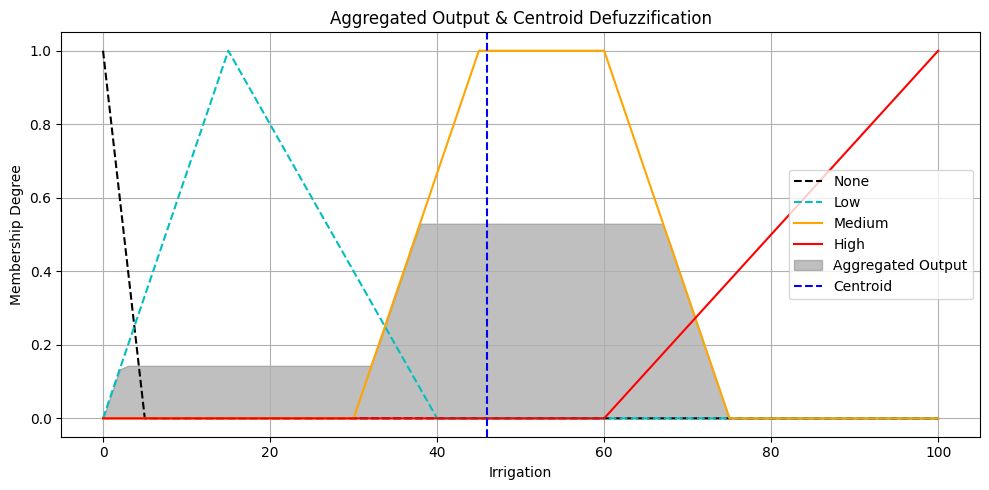

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(irrigation.universe, irrigation['none'].mf, 'k--', label='None')
plt.plot(irrigation.universe, irrigation['low'].mf, 'c--', label='Low')
plt.plot(irrigation.universe, irrigation['medium'].mf, 'orange', label='Medium')
plt.plot(irrigation.universe, irrigation['high'].mf, 'r', label='High')

plt.fill_between(irrigation.universe, aggregated_output, alpha=0.5, color='gray', label='Aggregated Output')
plt.axvline(crisp_output_centroid, color='blue', linestyle='--', label='Centroid')

plt.title('Aggregated Output & Centroid Defuzzification')
plt.xlabel('Irrigation')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### **First Maximum**

In [35]:
crisp_output_FM = fuzz.defuzz(irrigation.universe, aggregated_output, 'som')
print(f"\nFinal Irrigation Output (First of Maximum): {crisp_output_FM:.2f}")


Final Irrigation Output (First of Maximum): 38.00


##### **Visualization**

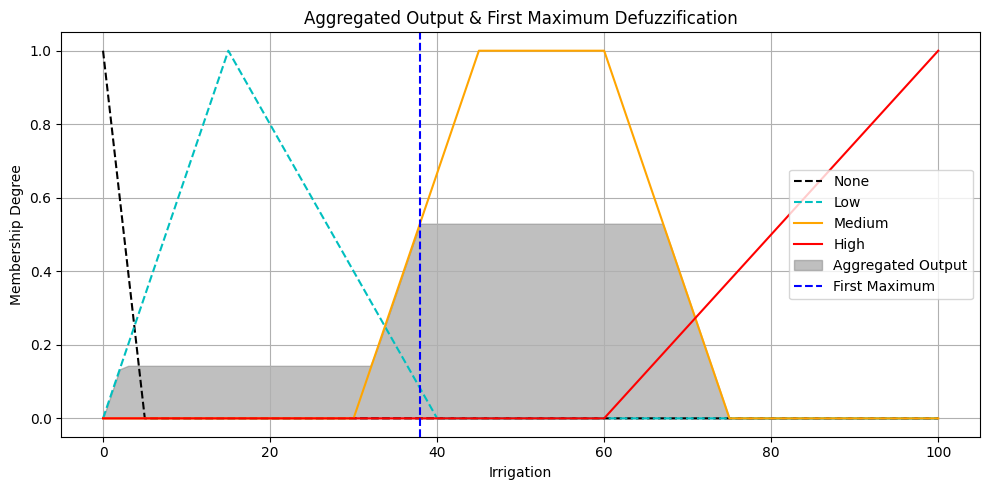

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(irrigation.universe, irrigation['none'].mf, 'k--', label='None')
plt.plot(irrigation.universe, irrigation['low'].mf, 'c--', label='Low')
plt.plot(irrigation.universe, irrigation['medium'].mf, 'orange', label='Medium')
plt.plot(irrigation.universe, irrigation['high'].mf, 'r', label='High')

plt.fill_between(irrigation.universe, aggregated_output, alpha=0.5, color='gray', label='Aggregated Output')
plt.axvline(crisp_output_FM, color='blue', linestyle='--', label='First Maximum')

plt.title('Aggregated Output & First Maximum Defuzzification')
plt.xlabel('Irrigation')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### **Middle Maximum**

In [37]:
crisp_output_MM = fuzz.defuzz(irrigation.universe, aggregated_output, 'mom')
print(f"\nFinal Irrigation Output (Mean of Maximum): {crisp_output_MM:.2f}")


Final Irrigation Output (Mean of Maximum): 52.50


##### **Visualization**

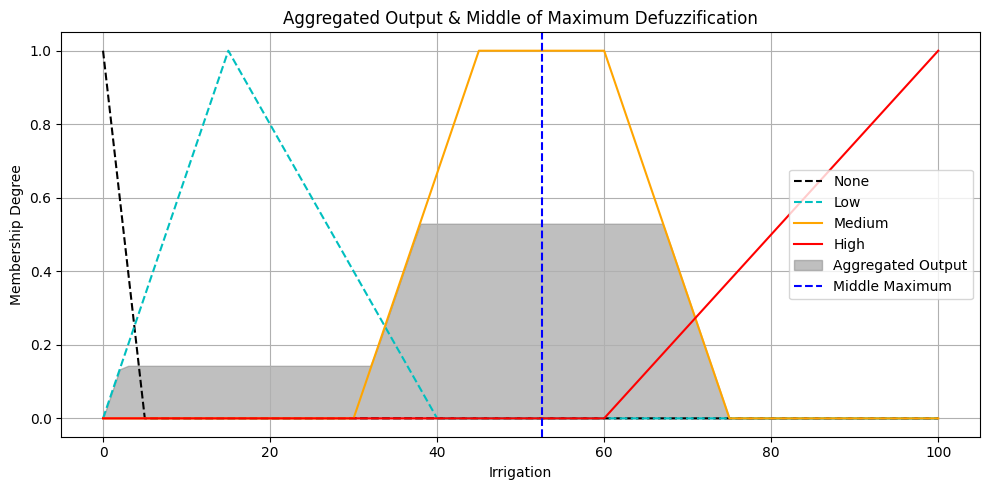

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(irrigation.universe, irrigation['none'].mf, 'k--', label='None')
plt.plot(irrigation.universe, irrigation['low'].mf, 'c--', label='Low')
plt.plot(irrigation.universe, irrigation['medium'].mf, 'orange', label='Medium')
plt.plot(irrigation.universe, irrigation['high'].mf, 'r', label='High')

plt.fill_between(irrigation.universe, aggregated_output, alpha=0.5, color='gray', label='Aggregated Output')
plt.axvline(crisp_output_MM, color='blue', linestyle='--', label='Middle Maximum')

plt.title('Aggregated Output & Middle of Maximum Defuzzification')
plt.xlabel('Irrigation')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### **Last Maximum**

In [39]:
crisp_output_LM = fuzz.defuzz(irrigation.universe, aggregated_output, 'lom')
print(f"\nFinal Irrigation Output (Last of Maximum): {crisp_output_LM:.2f}")


Final Irrigation Output (Last of Maximum): 67.00


##### **Visualization**

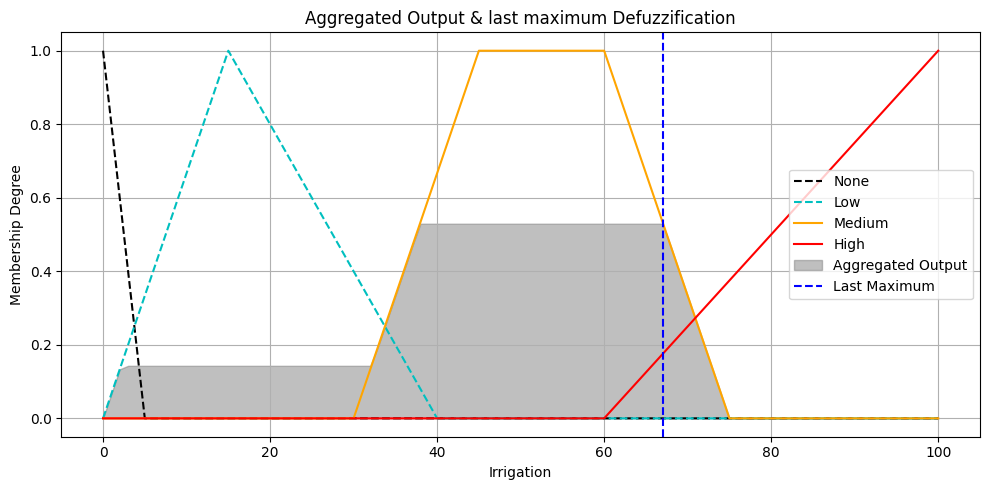

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(irrigation.universe, irrigation['none'].mf, 'k--', label='None')
plt.plot(irrigation.universe, irrigation['low'].mf, 'c--', label='Low')
plt.plot(irrigation.universe, irrigation['medium'].mf, 'orange', label='Medium')
plt.plot(irrigation.universe, irrigation['high'].mf, 'r', label='High')

plt.fill_between(irrigation.universe, aggregated_output, alpha=0.5, color='gray', label='Aggregated Output')
plt.axvline(crisp_output_LM, color='blue', linestyle='--', label='Last Maximum')

plt.title('Aggregated Output & last maximum Defuzzification')
plt.xlabel('Irrigation')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### **Center Of The Surface**

In [41]:
crisp_output_bisector = fuzz.defuzz(irrigation.universe, aggregated_output, 'bisector')
print(f"\nFinal Irrigation Output (bisector): {crisp_output:.2f}")


Final Irrigation Output (bisector): 45.97


##### **Visualization**

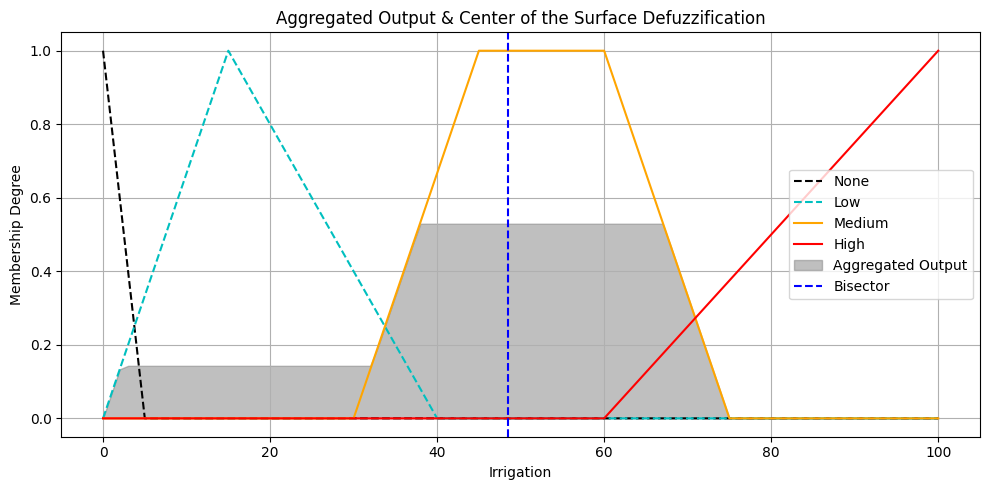

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(irrigation.universe, irrigation['none'].mf, 'k--', label='None')
plt.plot(irrigation.universe, irrigation['low'].mf, 'c--', label='Low')
plt.plot(irrigation.universe, irrigation['medium'].mf, 'orange', label='Medium')
plt.plot(irrigation.universe, irrigation['high'].mf, 'r', label='High')

plt.fill_between(irrigation.universe, aggregated_output, alpha=0.5, color='gray', label='Aggregated Output')
plt.axvline(crisp_output_bisector, color='blue', linestyle='--', label='Bisector')

plt.title('Aggregated Output & Center of the Surface Defuzzification')
plt.xlabel('Irrigation')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **Simulation and Analysis**